In [237]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Игнорирование сообщений с предупреждениями
import warnings
warnings.filterwarnings('ignore')

In [238]:
# Мониторинг состояния воздуха
# Загрузка датасета
data = pd.read_csv('/content/AirQualityData.csv')
data.head()

Date   Time    CO(GT)     NOx(GT)     NO2(GT)      O3(GT)    SO2(GT)  \
0  2024-01-01  00:00  3.807947  172.026768  144.333317  118.120832   1.215679   
1  2024-01-01  01:00  9.512072  241.824266  137.769318   15.325830   1.016178   
2  2024-01-01  02:00  7.346740  228.288118   20.055086   44.377036  24.140910   
3  2024-01-01  03:00  6.026719   47.016072  184.591909  139.488603   2.435392   
4  2024-01-01  04:00  1.644585   45.625591  114.125968   95.634768  48.752095   

        PM2.5        PM10  Temperature  ...  WindDirection  CO_NOx_Ratio  \
0  147.349671  208.803124    28.564580  ...     209.984267      0.022008   
1   40.979839  145.595579     6.793192  ...     319.534890      0.039173   
2   72.594740   26.155000    24.436552  ...     274.644300      0.032042   
3  134.339724  276.367944    26.463951  ...     312.266023      0.125515   
4   99.007422  294.295449    10.530331  ...      21.392120      0.035272   

   NOx_NO2_Ratio  Temp_Humidity_Index  AirQualityIndex    CO_MA3     NO2_MA3  \
0       1.183671             3.541778       343.353046  3.807947  144.333317   
1       1.742635             0.727989       206.282028  6.660009  141.051317   
2      10.842422             7.378322       140.170920  6.888920  100.719240   
3       0.253330            21.684266       307.928588  7.628510  114.138771   
4       0.396310             9.627596       370.134556  5.006015  106.257654   

       O3_MA3  DayOfWeek  Hour  
0  118.120832          0     0  
1   66.723331          0     1  
2   59.274566          0     2  
3   66.397156          0     3  
4   93.166802          0     4  

[5 rows x 23 columns]

In [239]:
# Общая информация
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 4000 non-null   object 
 1   Time                 4000 non-null   object 
 2   CO(GT)               4000 non-null   float64
 3   NOx(GT)              4000 non-null   float64
 4   NO2(GT)              4000 non-null   float64
 5   O3(GT)               4000 non-null   float64
 6   SO2(GT)              4000 non-null   float64
 7   PM2.5                4000 non-null   float64
 8   PM10                 4000 non-null   float64
 9   Temperature          4000 non-null   float64
 10  Humidity             4000 non-null   float64
 11  Pressure             4000 non-null   float64
 12  WindSpeed            4000 non-null   float64
 13  WindDirection        4000 non-null   float64
 14  CO_NOx_Ratio         4000 non-null   float64
 15  NOx_NO2_Ratio        4000 non-null   f

 Датасет содержит 23 поля предоставляющих следующую информацию:

Date (object) - дата наблюдения в формате YYYY-MM-DD. Для каждой даты имеется до 24 записей о наблюдениях с уникальным временем наблюдения. Наблюдения охватывают период в 167 дней с 01.01.2024 по 15.06.2024

Time (object) - время наблюдения в формате HH:MM. Для каждой даты за исключением 15.06.2024 проведено 24 наблюдения с интервалом в 1 час. Поле содержит 24 уникальных значения от 00:00 до 23:00

Поскольку при анализе и для построения временного ряда будут использоваться все записи, поля Date и Time целесообразно объединить в одно поле типа (DateTime), содержащее полную временную метку формата YYYY-MM-DD HH:MM, или заменить полем типа (int64), содержащим порядковый номер наблюдения от 1 до 4000.

-----------------------------

CO(GT) (float64) - концентрация угарного газа (CO) в мг/м3

NOx(GT) (float64) - концентрация различных оксидов азота (NOx) кроме NO2 в миллиардных долях (ppb)

NO2(GT) (float64) - концентрация диоксида азота (NO2) в миллиардных долях (ppb)

O3(GT) (float64) - концентрация озона (O3) в миллиардных долях (ppb)

SO2(GT) (float64) - концентрация диоксида серы (SO2) в миллиардных долях (ppb)

PM2.5 (float64) - концентрация мелких твердых частиц в воздухе в мкг/м3

PM10 (float64) - концентрация крупных твердых частиц в воздухе в мкг/м3

-----------------------------

Temperature (float64) - температура воздуха в °С

Humidity (float64) - влажность воздуха в %

Pressure (float64) - атмосферное давление в мбар

WindSpeed (float64) - скорость ветра в м/с

WindDirection (float64) - направление ветра в °

-----------------------------

CO_NOx_Ratio (float64) - соотношение содержания угарного газа и оксидов азота

NOx_NO2_Ratio (float64) - соотношение содержания прочих оксидов азота и NO2

Temp_Humidity_Index (float64) - индекс температуры и влажности (THI)

AirQualityIndex (float64) - индекс качества воздуха. Количественно оценивается, как правило, от 0 до 500 (чем меньше, тем лучше). Качественная и количественная оценка зависит от государства и специфики расчета. При необходимости будет использоваться американская цветовая система оценки:
0-50    | Good                  | Зеленый
51-100  | Moderate              | Желтый
101-150 | Unhealthy (Sensitive) | Оранжевый
151-200 | Unhealthy             | Красный
201-300 | Very Unhealthy        | Фиолетовый
301-500 | Hazardous             | Бордовый

CO_MA3 (float64) - скользящее среднее значение концентрации угарного газа

NO2_MA3 (float64) - скользящее среднее значение концентрации диоксида азота

O3_MA3 (float64) - скользящее среднее значение концентрации озона

DayOfWeek (int64) - день недели. Дни недели представлены целыми числами [0:6]. 0 - понедельник. Целесообразно дополнительно изучить влияние данного параметра, поскольку производственный календарь влияет на выброс отходов в атмосферу, однако производственный календарь связан не только со структурой недели.

Hour (int64) - часы с начала суток. Представлены целыми числами [0:23]. Дублирование информации с полем Time. Целесообразно исключить как дублирующую информацию.

In [240]:
# Проверка на пустые значения
data.isnull().sum()

Date                   0
Time                   0
CO(GT)                 0
NOx(GT)                0
NO2(GT)                0
O3(GT)                 0
SO2(GT)                0
PM2.5                  0
PM10                   0
Temperature            0
Humidity               0
Pressure               0
WindSpeed              0
WindDirection          0
CO_NOx_Ratio           0
NOx_NO2_Ratio          0
Temp_Humidity_Index    0
AirQualityIndex        0
CO_MA3                 0
NO2_MA3                0
O3_MA3                 0
DayOfWeek              0
Hour                   0
dtype: int64

Датасет не содержит пустых значений

In [241]:
# Проверка на наличие дубликатов
data.duplicated().sum()

np.int64(0)

Датасет не содержит дублирующихся записей

In [242]:
# Общие характеристики
data.describe()

CO(GT)      NOx(GT)      NO2(GT)       O3(GT)      SO2(GT)  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean      5.025385   148.126633   100.213189    89.914815    26.081045   
std       2.874632    85.999247    57.074947    52.003484    14.059684   
min       0.100115     1.009185     1.010513     1.055442     1.012370   
25%       2.514242    73.636615    51.326622    44.179487    14.220565   
50%       5.054973   146.440690    99.508855    88.956924    26.321359   
75%       7.524652   221.823697   149.666167   136.333683    37.833728   
max       9.997205   299.838744   199.934968   179.986544    49.993700   

             PM2.5         PM10  Temperature     Humidity     Pressure  ...  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000  ...   
mean    104.765999   153.591417    17.305228    54.626284   999.862679  ...   
std      56.344868    83.080911    12.943632    25.844003    28.897118  ...   
min       5.009384    10.031967    -4.996963    10.000498   950.018004  ...   
25%      56.544378    82.200105     6.092531    31.970628   975.018939  ...   
50%     105.502686   154.714484    17.184773    55.113650   999.857722  ...   
75%     153.751364   222.969347    28.573093    76.311009  1024.763352  ...   
max     199.980691   299.911727    39.987944    99.981043  1049.926869  ...   

       WindDirection  CO_NOx_Ratio  NOx_NO2_Ratio  Temp_Humidity_Index  \
count    4000.000000   4000.000000    4000.000000          4000.000000   
mean      179.571724      0.082564       3.412176             9.418823   
std       104.738760      0.215593       7.996062             8.982090   
min         0.033694      0.000389       0.006021            -4.824570   
25%        86.409827      0.017033       0.719052             2.551932   
50%       179.401393      0.034021       1.467460             6.975287   
75%       272.370032      0.065973       2.789423            14.752847   
max       359.984504      4.078615     131.169948            39.372679   

       AirQualityIndex       CO_MA3      NO2_MA3       O3_MA3    DayOfWeek  \
count      4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean        249.602455     5.025846   100.222672    89.901700     2.978000   
std         143.570929     1.672715    32.884870    30.505331     1.992614   
min           0.052355     0.612983     3.702628     7.453898     0.000000   
25%         124.521801     3.846779    77.100651    68.321846     1.000000   
50%         250.552671     5.042259   100.128466    90.452301     3.000000   
75%         370.997732     6.206658   123.919621   111.337587     5.000000   
max         499.920650     9.471079   190.781333   173.546840     6.000000   

              Hour  
count  4000.000000  
mean     11.484000  
std       6.919951  
min       0.000000  
25%       5.000000  
50%      11.000000  
75%      17.000000  
max      23.000000  

[8 rows x 21 columns]

In [243]:
# Формирование единого поля даты и времени
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('DateTime', inplace=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)

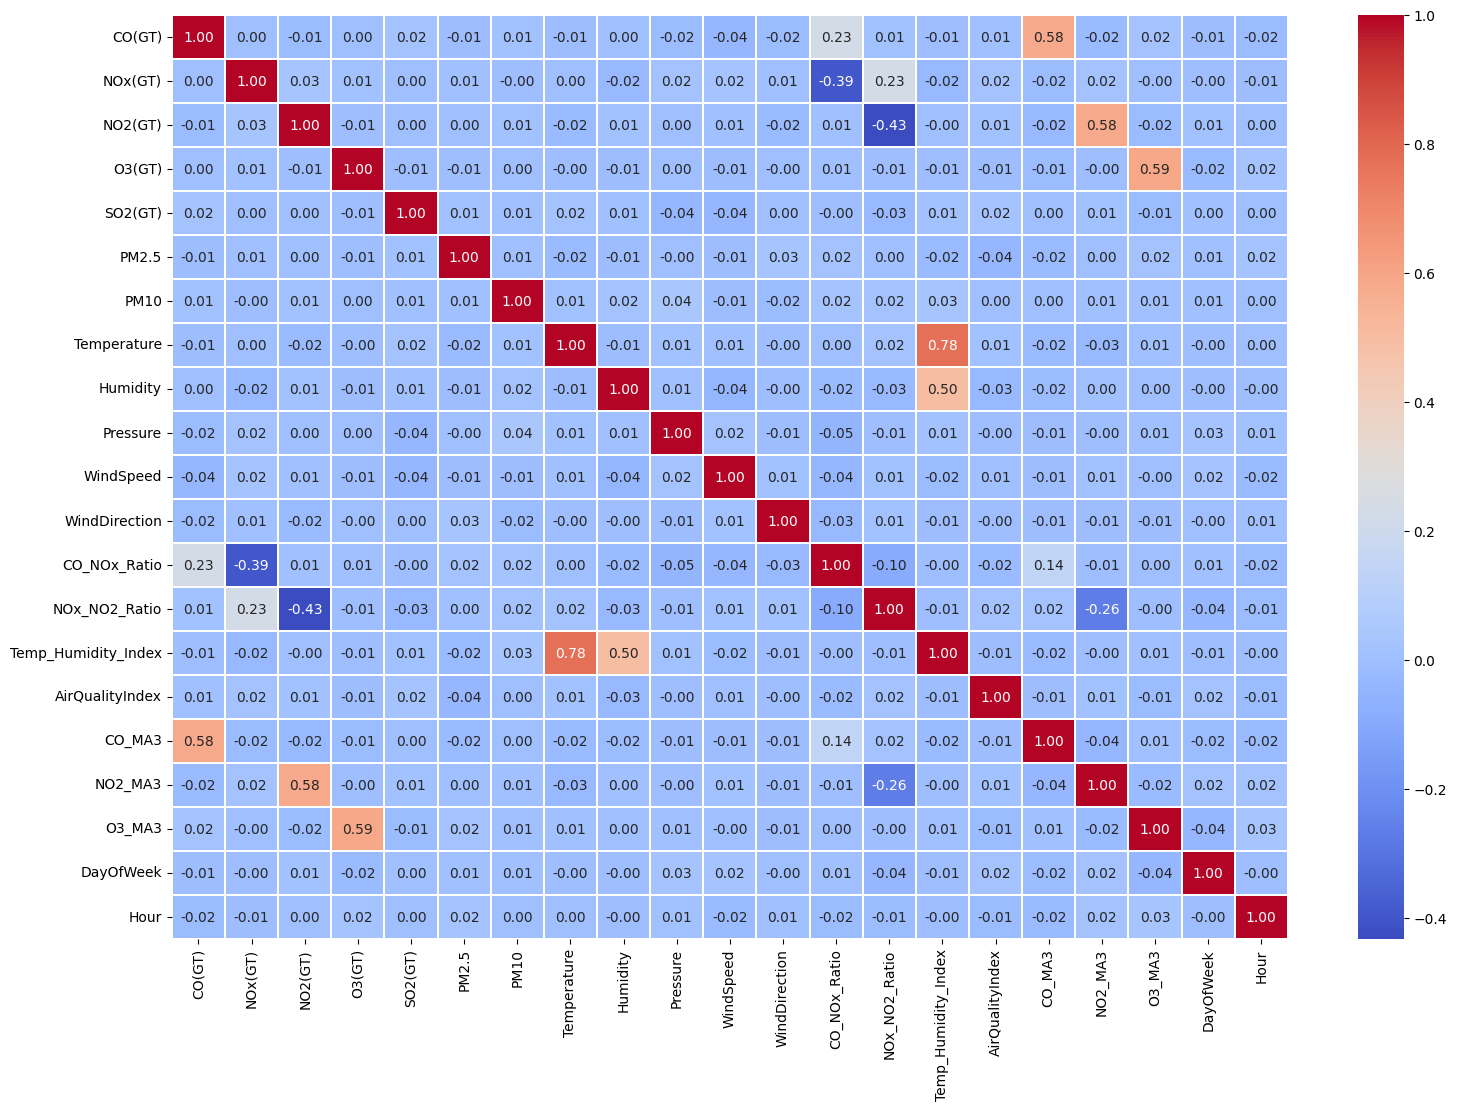

In [244]:
# Корреляция параметров
plt.figure(figsize=(18,12))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.01)
plt.show()

Высокая корреляция между отдельными параметрами связана с тем, что ряд параметров в датасете является производными от других параметров датасета

Целесообразно рассмотреть варианты, когда учитываются отдельно Temperature и Humidity и когда учитывается производный от них параметр Temp_Humidity_Index

Пары между значениями концентрации отдельных газов и их плавающих средних значений также достаточно сильно коррелируют между собой

Число выбросов в параметре:
 CO(GT)                   0
NOx(GT)                  0
NO2(GT)                  0
O3(GT)                   0
SO2(GT)                  0
PM2.5                    0
PM10                     0
Temperature              0
Humidity                 0
Pressure                 0
WindSpeed                0
WindDirection            0
CO_NOx_Ratio           459
NOx_NO2_Ratio          444
Temp_Humidity_Index     57
AirQualityIndex          0
CO_MA3                   0
NO2_MA3                  2
O3_MA3                   0
DayOfWeek                0
Hour                     0
dtype: int64


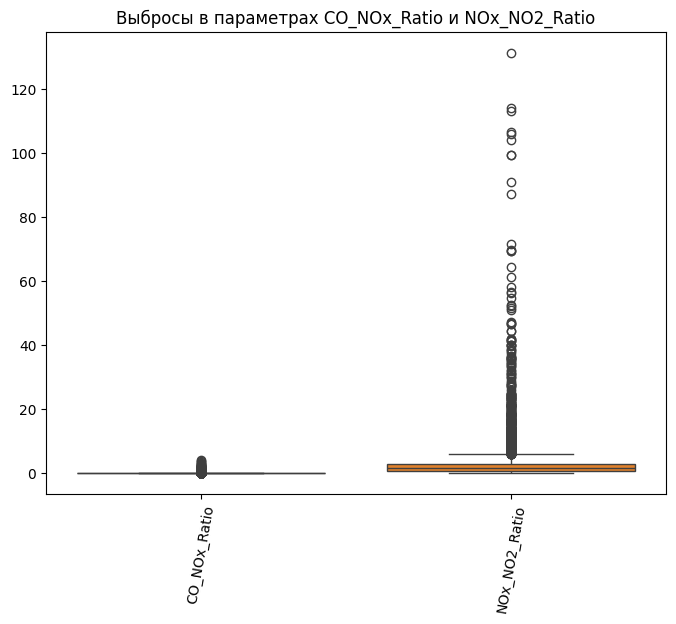

In [245]:
# Поиск выбросов по IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
print("Число выбросов в параметре:\n", outliers)

plt.figure(figsize=(8,6))
sns.boxplot([data['CO_NOx_Ratio'], data['NOx_NO2_Ratio']])
plt.xticks(rotation = 80)
plt.title('Выбросы в параметрах CO_NOx_Ratio и NOx_NO2_Ratio')
plt.show()

Большое количество выбросов для производных параметров CO_NOx_Ratio и NOx_NO2_Ratio говорит об их потенциальной нестабильности. В случае использования этих параметров в дальнейшем целесообразно дополнительно подготовить их во избежание нестабильности модели.

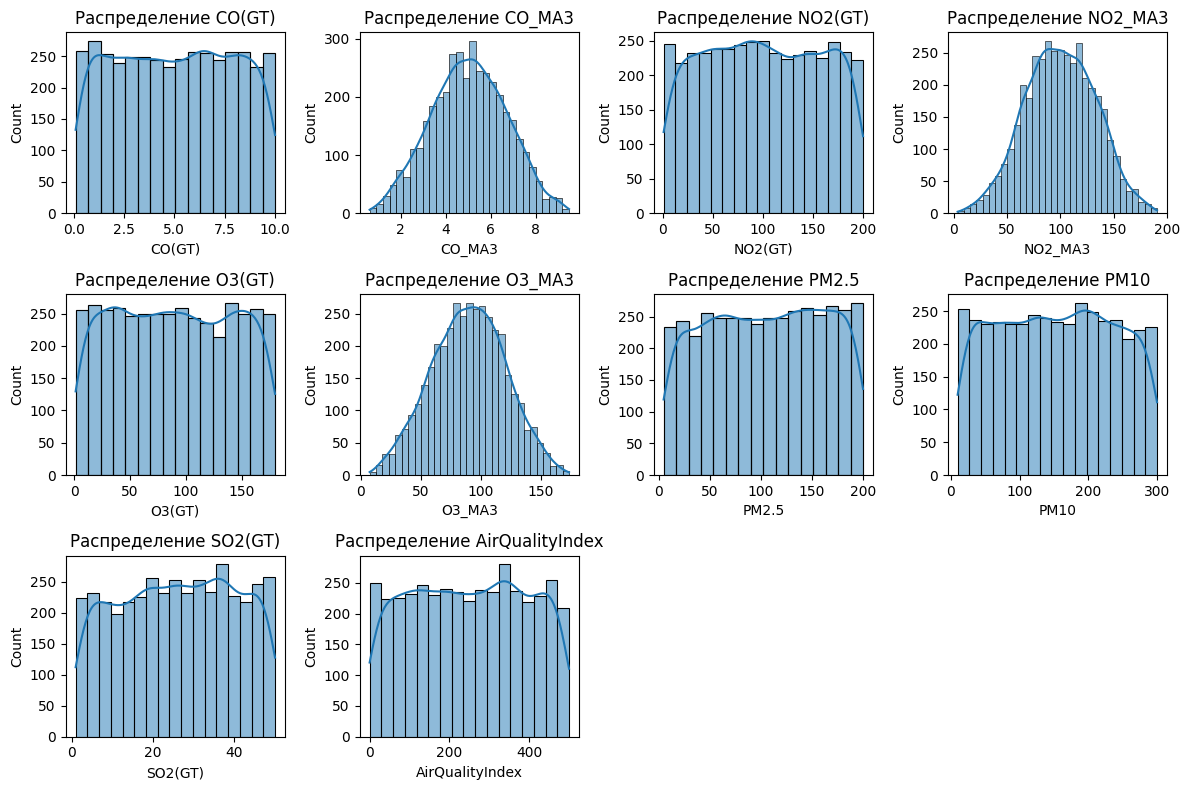

In [246]:
# Визуализация распределения параметров
plt.figure(figsize=(12, 8))
for i, col in enumerate(['CO(GT)', 'CO_MA3','NO2(GT)', 'NO2_MA3',
                         'O3(GT)', 'O3_MA3', 'PM2.5',	'PM10','SO2(GT)',
                         'AirQualityIndex']):
    plt.subplot(3, 4, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

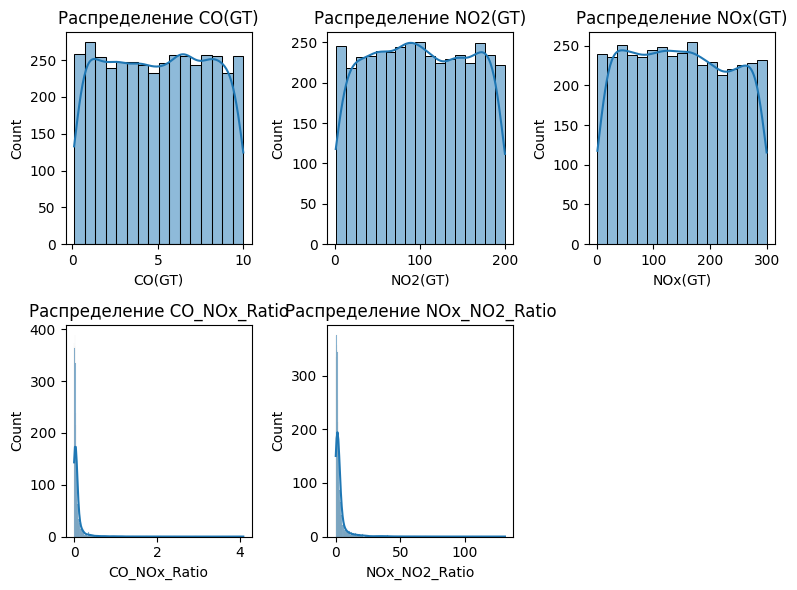

In [247]:
# Визуализация распределения параметров
plt.figure(figsize=(8, 6))
for i, col in enumerate(['CO(GT)', 'NO2(GT)', 'NOx(GT)',
                         'CO_NOx_Ratio',	'NOx_NO2_Ratio']):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

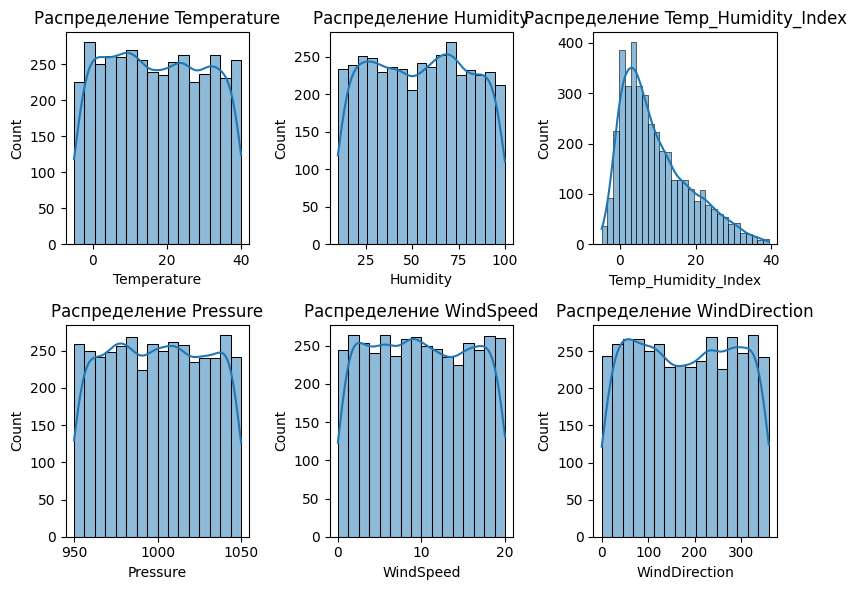

In [248]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(['Temperature',	'Humidity',	'Temp_Humidity_Index',
                         'Pressure', 'WindSpeed', 'WindDirection', ]):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

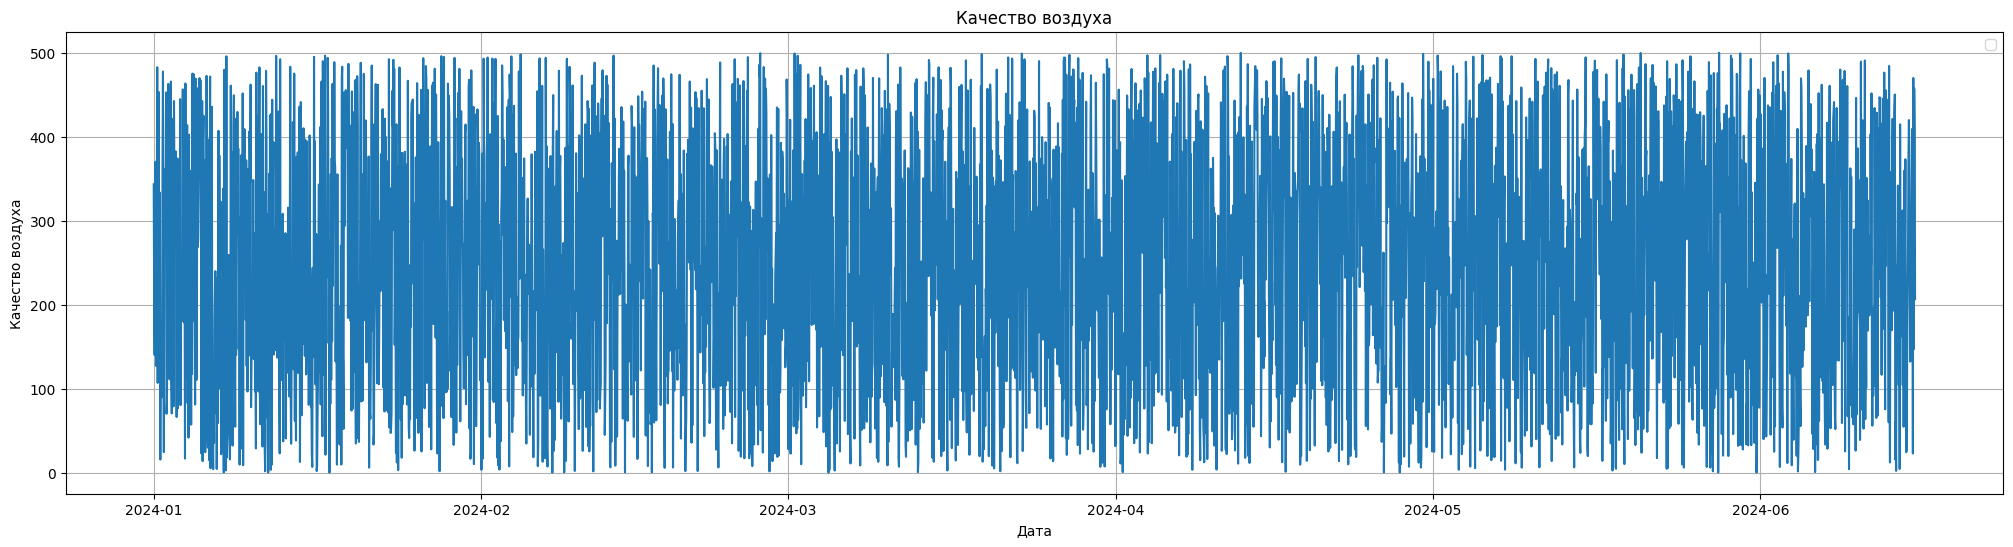

In [249]:
# Визуализация временного ряда
plt.figure(figsize=(25, 6))
plt.plot(data.index, data['AirQualityIndex'])
plt.title("Качество воздуха")
plt.xlabel("Дата")
plt.ylabel("Качество воздуха")
plt.grid(True)
plt.legend()
plt.show()

In [250]:
# Тест ADF на нестационарность
result = adfuller(data['AirQualityIndex'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -34.861082
p-value: 0.000000
	1%: -3.432
	5%: -2.862
	10%: -2.567


ADF тест указывает на стационарность временного ряда, что говорит об отсутствии выраженной цикличности

<Figure size 1800x400 with 0 Axes>

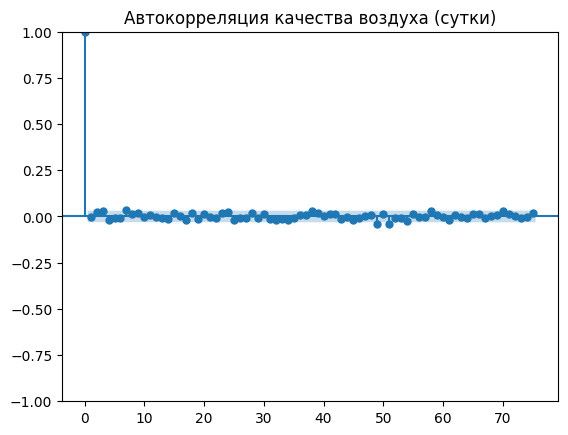

<Figure size 1800x400 with 0 Axes>

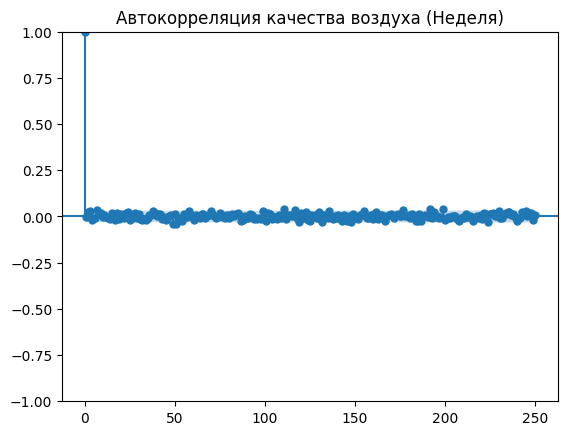

<Figure size 1800x400 with 0 Axes>

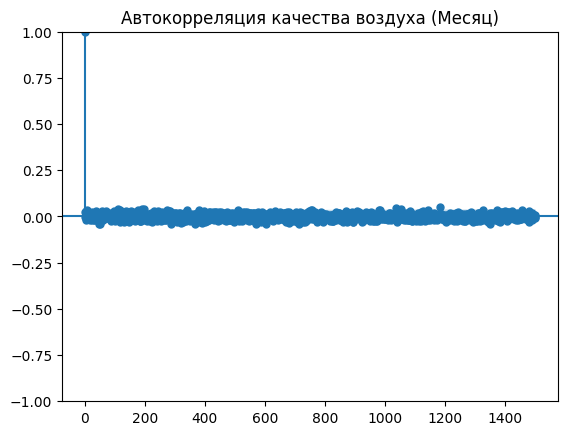

In [251]:
# Поиск сезонности с использованием графика автокорреляции

# Построение графиков автокорреляции
plt.figure(figsize=(18, 4))
plot_acf(data['AirQualityIndex'], lags=75)
plt.title('Автокорреляция качества воздуха (сутки)')
plt.show()

plt.figure(figsize=(18, 4))
plot_acf(data['AirQualityIndex'], lags=250)
plt.title('Автокорреляция качества воздуха (Неделя)')
plt.show()

plt.figure(figsize=(18, 4))
plot_acf(data['AirQualityIndex'], lags=1500)
plt.title('Автокорреляция качества воздуха (Месяц)')
plt.show()

Отсутствие заметной автокорреляции подтверждает отсутствие суточной/недельной/месячной цикличности (сезонности) изменений качества воздуха.

In [269]:
# Определение признаков и целевого параметра
data_cleaned = data.drop(['Temp_Humidity_Index', 'DayOfWeek', 'Hour'], axis=1)

# Ограничение значений выбросов
for col in ['CO_NOx_Ratio', 'NOx_NO2_Ratio']:
    cap_value = data_cleaned[col].quantile(0.95)
    data_cleaned[col] = np.clip(data_cleaned[col], data_cleaned[col].min(), cap_value)

num_cols = ['CO(GT)',	'NOx(GT)',	'NO2(GT)',	'O3(GT)',	'SO2(GT)',	'PM2.5',
            'PM10',	'Temperature',	'Humidity',	'Pressure',	'WindDirection',
            'CO_NOx_Ratio',	'NOx_NO2_Ratio',	'CO_MA3',	'NO2_MA3',	'O3_MA3']
scaler = StandardScaler()
data_cleaned[num_cols] = scaler.fit_transform(data_cleaned[num_cols])

Из набора признаков на этом этапе исключен индекс температуры и влажности (THI) из-за высокой корреляции с температурой воздуха.

Признаки 'Hour' и 'DayOfWeek' также исключены: первый фактически учитывается в поле 'DateTime', а изучение автокорреляции не выявило явной связи между качеством воздуха и временем или днём проведения измерений

Поскольку данные содержат временной ряд и отсортированы по времени наблюдений, для тестовых данных ,elen jn,bhfnmcz последние 20% данных датасета

In [287]:
# Обучение модели ARIMA

data_train = data_cleaned[0:3200]
data_test = data_cleaned[3200:4000]

model = ARIMA(data_train['AirQualityIndex'], order=(1,1,1))
model_arima = model.fit()
print(model_arima.summary())

# Прогнозирование для тестовой выборки
forecast_arima = model_arima.forecast(steps=len(data_test['AirQualityIndex']))

                               SARIMAX Results                                
Dep. Variable:        AirQualityIndex   No. Observations:                 3200
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20419.397
Date:                Wed, 07 May 2025   AIC                          40844.795
Time:                        00:09:20   BIC                          40863.007
Sample:                    01-01-2024   HQIC                         40851.324
                         - 05-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0135      0.018     -0.757      0.449      -0.048       0.021
ma.L1         -0.9983      0.001   -704.224      0.000      -1.001      -0.996
sigma2      2.047e+04    792.083     25.838      0.0

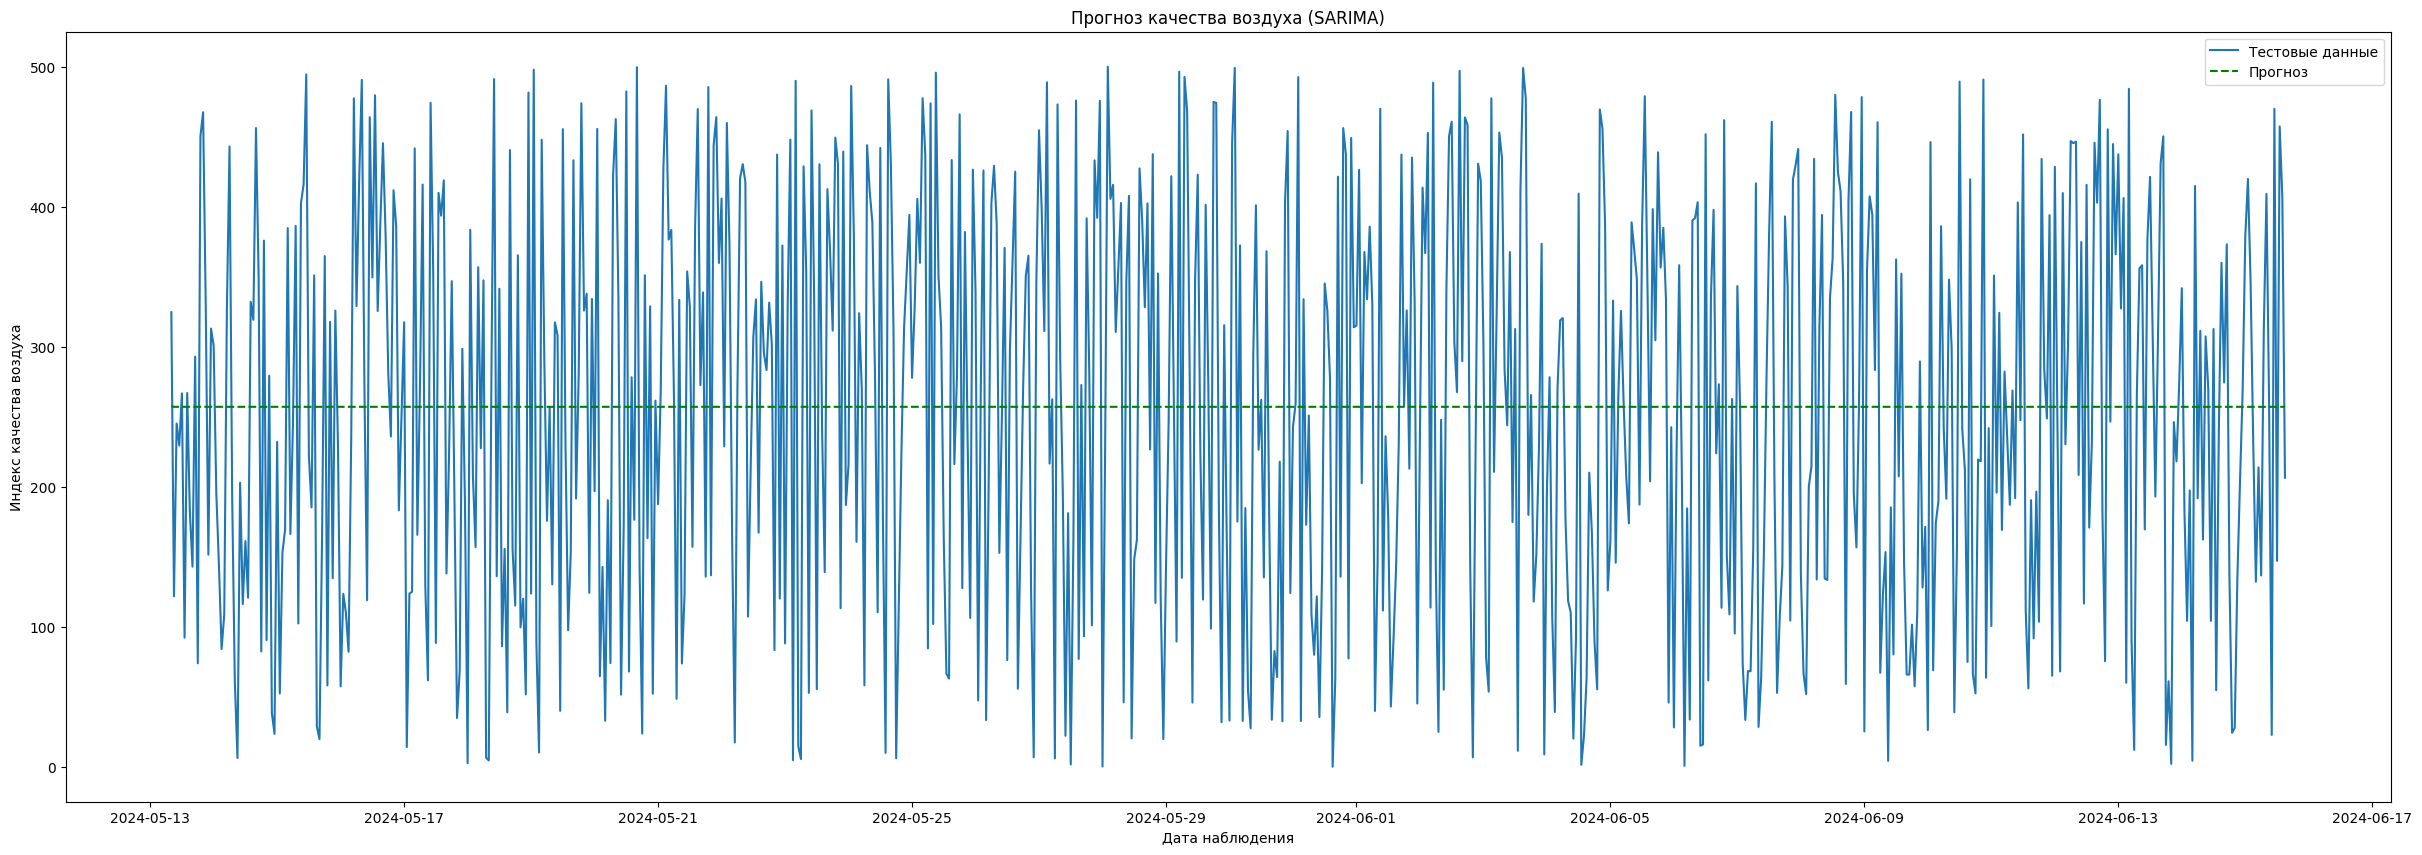

Mean Absolute Error (MAE): 127.272
Mean Squared Error (MSE): 21174.335
Root Mean Squared Error (RMSE): 145.514
Mean Absolute Percentage Error (MAPE): 561.220%


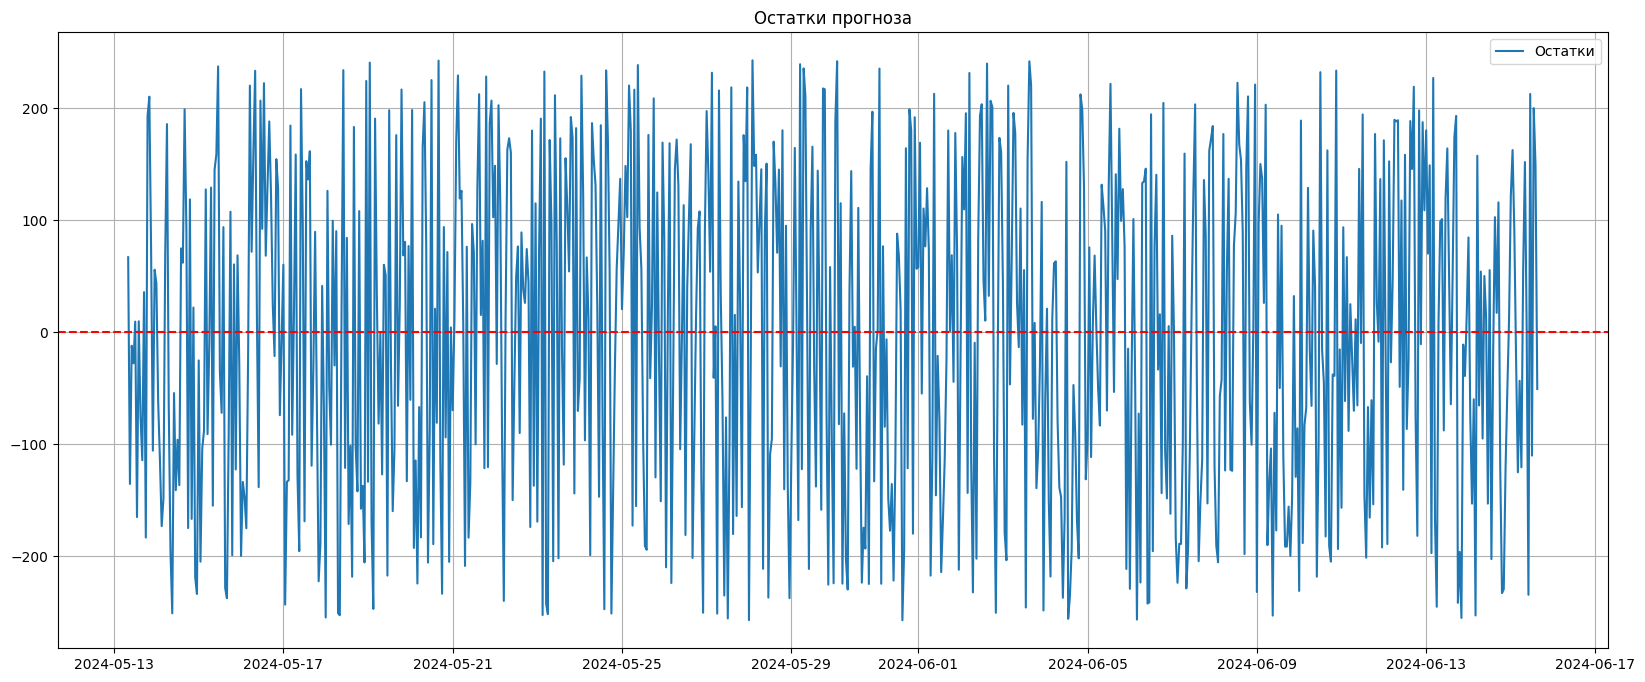

In [288]:
# Визуализация прогноза на тестовой выборке
plt.figure(figsize=(30, 10))
plt.plot(data_test.index, data_test['AirQualityIndex'], label='Тестовые данные')
plt.plot(data_test.index, forecast_arima, color='green', linestyle='--', label='Прогноз')
plt.title('Прогноз качества воздуха (SARIMA)')
plt.xlabel('Дата наблюдения')
plt.ylabel('Индекс качества воздуха')
plt.legend()
plt.show()

# Метрики качества
mae = mean_absolute_error(data_test['AirQualityIndex'], forecast_arima)
mse = mean_squared_error(data_test['AirQualityIndex'], forecast_arima)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((data_test['AirQualityIndex'] - forecast_arima) / data_test['AirQualityIndex'])) * 100

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.3f}%')

# Визуализация остатков
residuals = data_test['AirQualityIndex'] - forecast_arima
plt.figure(figsize=(20, 8))
plt.plot(residuals, label='Остатки')
plt.axhline(0, linestyle='--', color='red')
plt.title('Остатки прогноза')
plt.legend()
plt.grid(True)
plt.show()

In [270]:
# Прогноз с использованием случайного леса

f_data = data_cleaned

X_forest = f_data.drop('AirQualityIndex', axis=1)
y_forest = f_data['AirQualityIndex']

# Подготовка тренировочных и тестовых данных
X_forest_train = X_forest[0:3200]
X_forest_test = X_forest[3200:4000]
y_forest_train = y_forest[0:3200]
y_forest_test = y_forest[3200:4000]

# Создание и обучение модели случайного леса
model_forest = RandomForestRegressor(n_estimators=100)
model_forest.fit(X_forest_train, y_forest_train)
forecast_forest = model_forest.predict(X_forest_test)

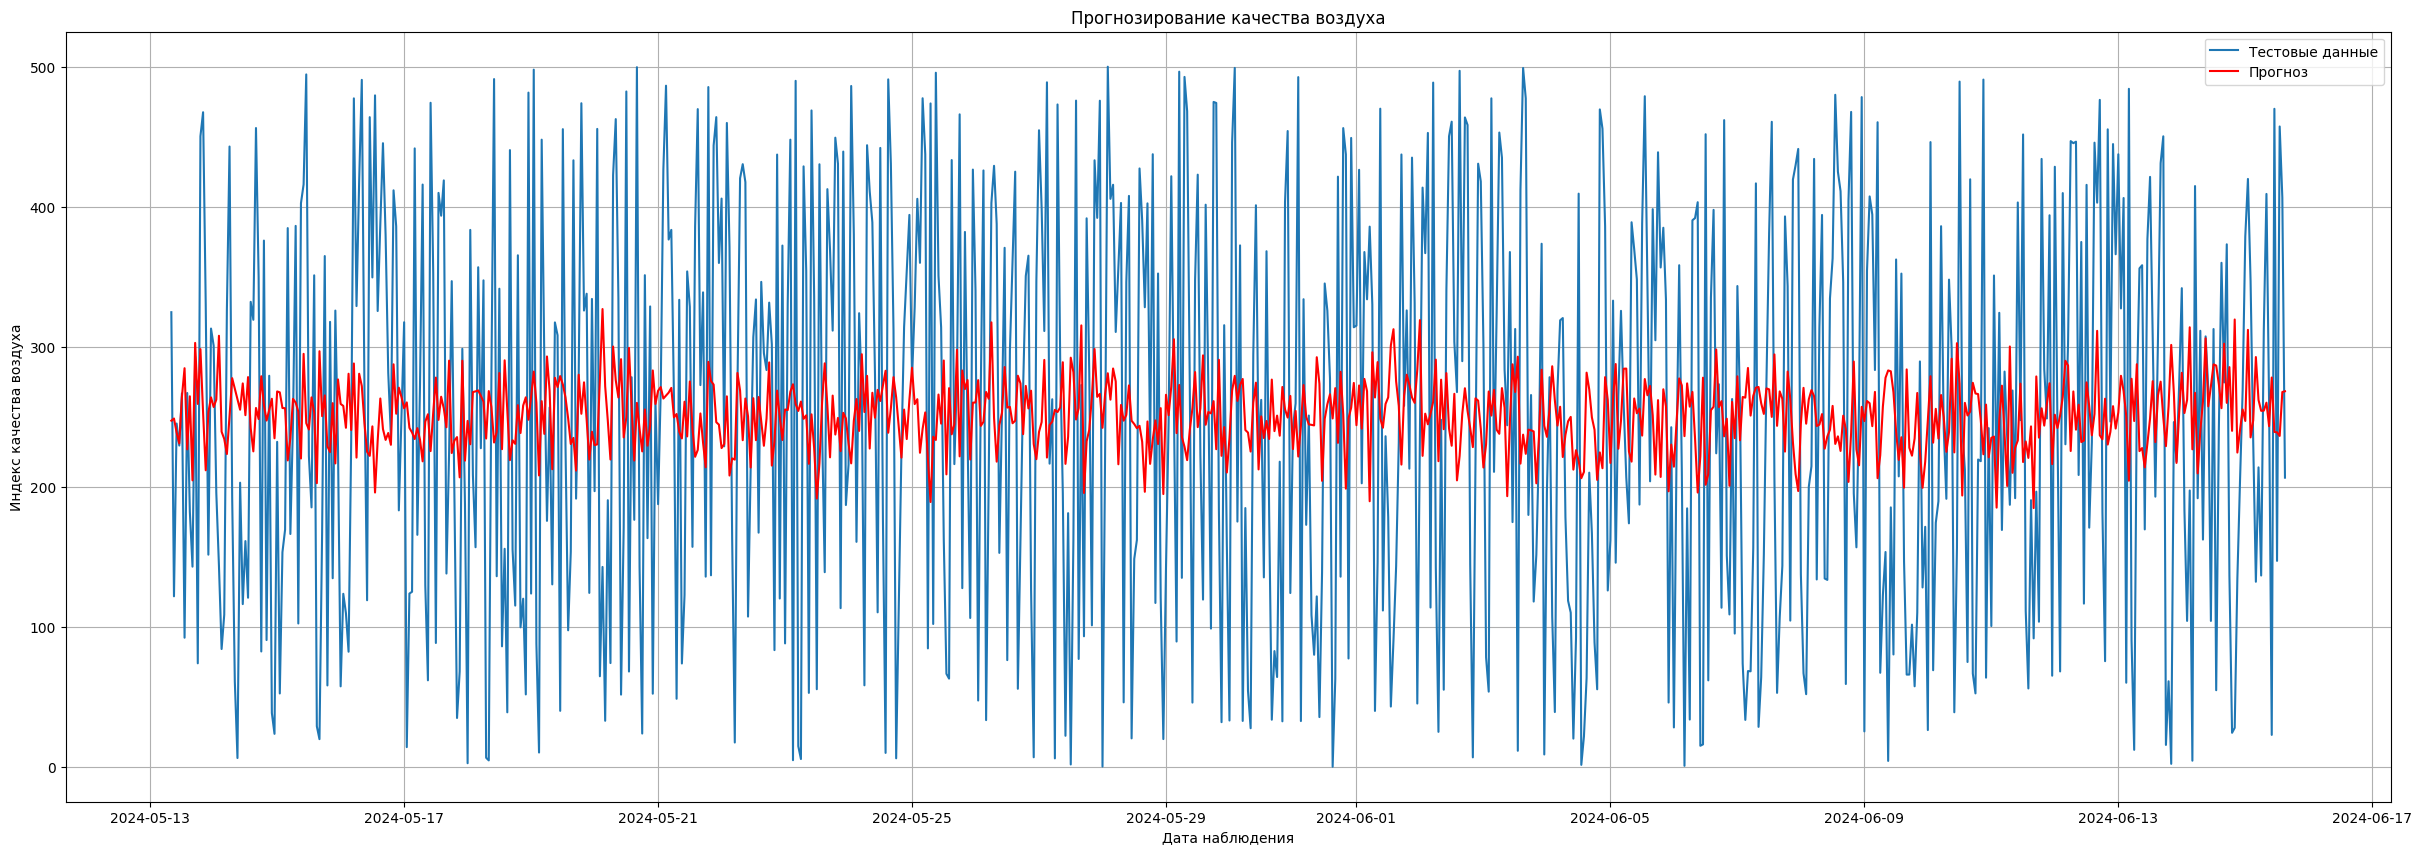

Mean Absolute Error (MAE): 128.627
Mean Squared Error (MSE): 21950.526
Root Mean Squared Error (RMSE): 148.157


In [271]:
# Визуализация прогноза
plt.figure(figsize=(30, 10))
plt.plot(X_forest_test.index, y_forest_test, label='Тестовые данные')
plt.plot(X_forest_test.index, forecast_forest, color='red', label='Прогноз')
plt.title('Прогнозирование качества воздуха')
plt.xlabel('Дата наблюдения')
plt.ylabel('Индекс качества воздуха')
plt.legend()
plt.grid(True)
plt.show()

# Оценка точности прогноза
mse = mean_squared_error(y_forest_test, forecast_forest)
mae = mean_absolute_error(y_forest_test, forecast_forest)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

In [272]:
# Использование Gradient Boosting для прогноза

gb_data = data_cleaned

X_gb = gb_data.drop('AirQualityIndex', axis=1)
y_gb = gb_data['AirQualityIndex']

X_gb_train = X_gb[0:3200]
X_gb_test = X_gb[3200:4000]
y_gb_train = y_gb[0:3200]
y_gb_test = y_gb[3200:4000]

model_gb = GradientBoostingRegressor(n_estimators=100)
model_gb.fit(X_gb_train, y_gb_train)
forecast_gb = model_gb.predict(X_gb_test)

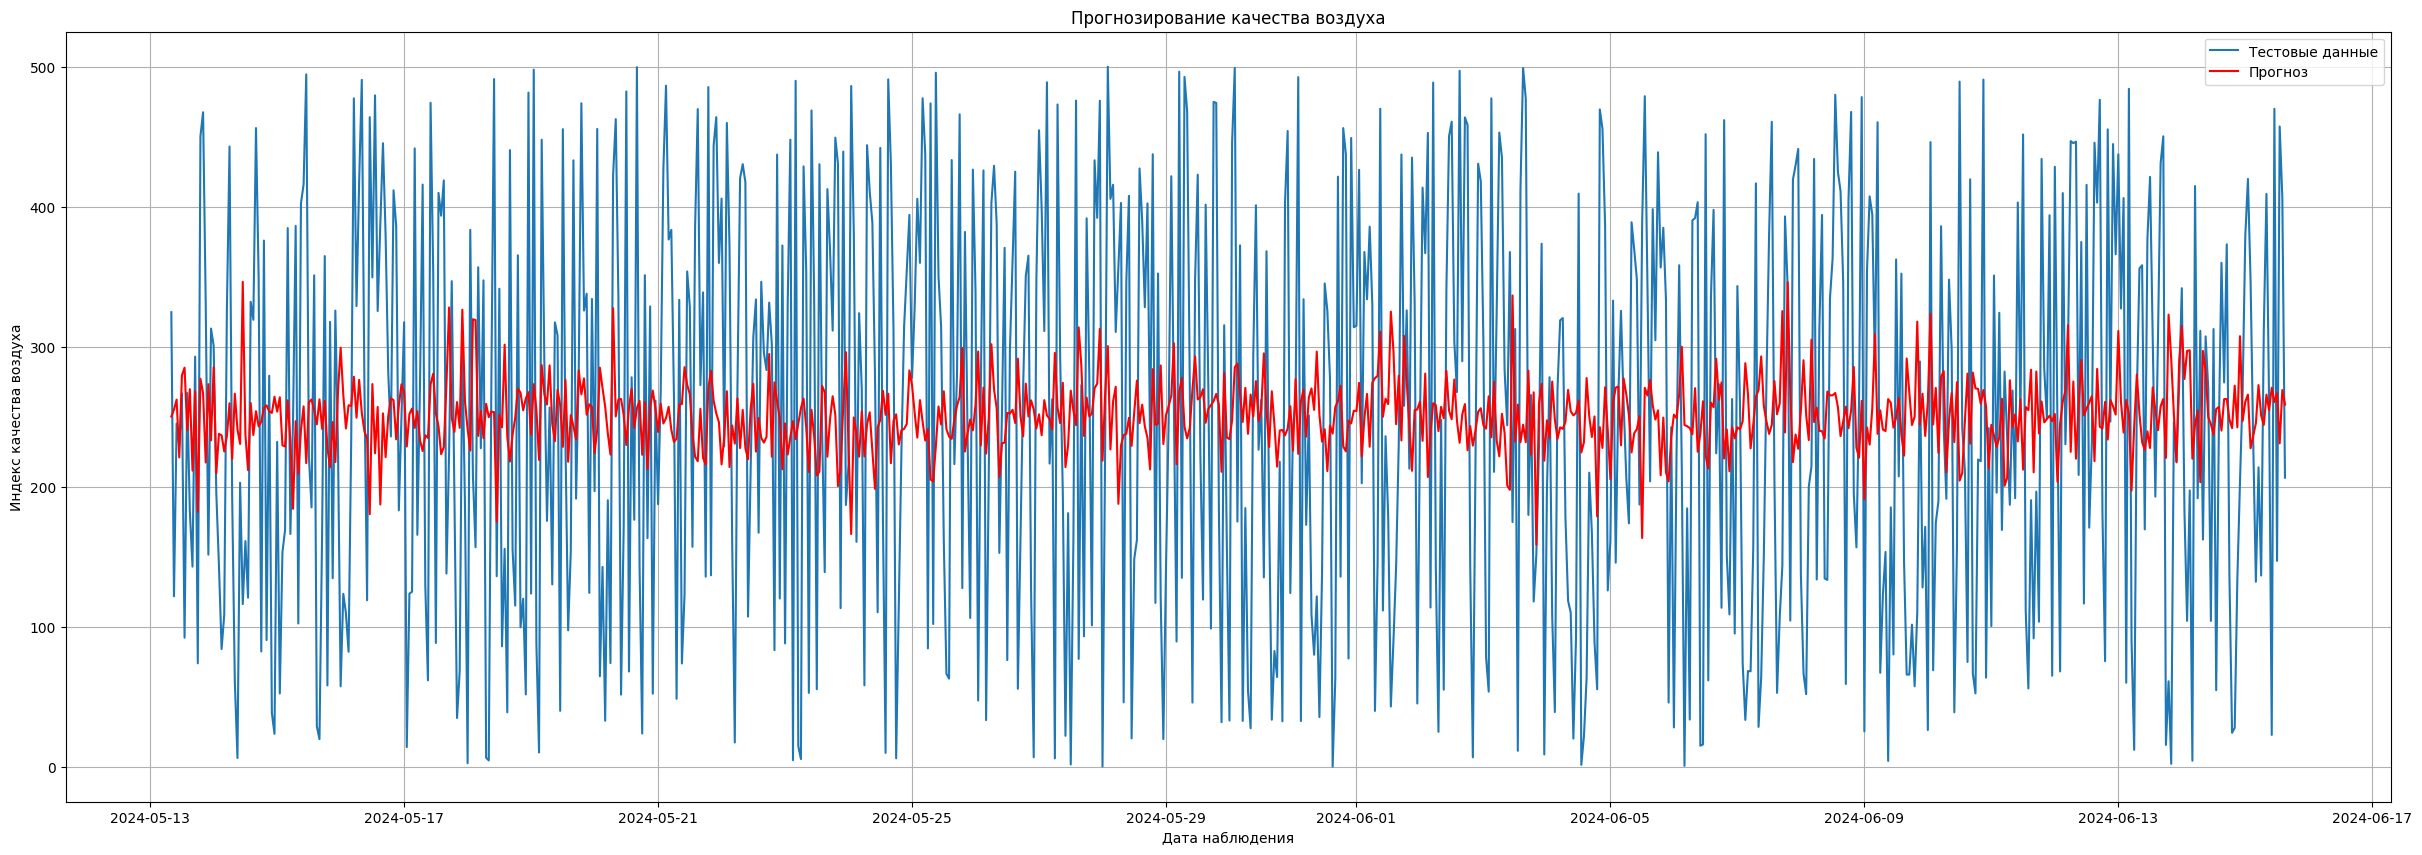

Mean Absolute Error (MAE): 129.914
Mean Squared Error (MSE): 22112.634
Root Mean Squared Error (RMSE): 148.703


In [273]:
# Визуализация прогноза
plt.figure(figsize=(30, 10))
plt.plot(X_gb_test.index, y_gb_test, label='Тестовые данные')
plt.plot(X_gb_test.index, forecast_gb, color='red', label='Прогноз')
plt.title('Прогнозирование качества воздуха')
plt.xlabel('Дата наблюдения')
plt.ylabel('Индекс качества воздуха')
plt.legend()
plt.grid(True)
plt.show()

# Оценка точности прогноза
mse = mean_squared_error(y_gb_test, forecast_gb)
mae = mean_absolute_error(y_gb_test, forecast_gb)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

In [274]:
# Использование XGBoost для прогноза

xgb_data = data_cleaned

X_xgb = xgb_data.drop('AirQualityIndex', axis=1)
y_xgb = xgb_data['AirQualityIndex']

X_xgb_train = X_gb[0:3200]
X_xgb_test = X_gb[3200:4000]
y_xgb_train = y_gb[0:3200]
y_xgb_test = y_gb[3200:4000]

model_xgb = XGBRegressor(n_estimators=100)
model_xgb.fit(X_xgb_train, y_xgb_train)
forecast_xgb = model_xgb.predict(X_xgb_test)

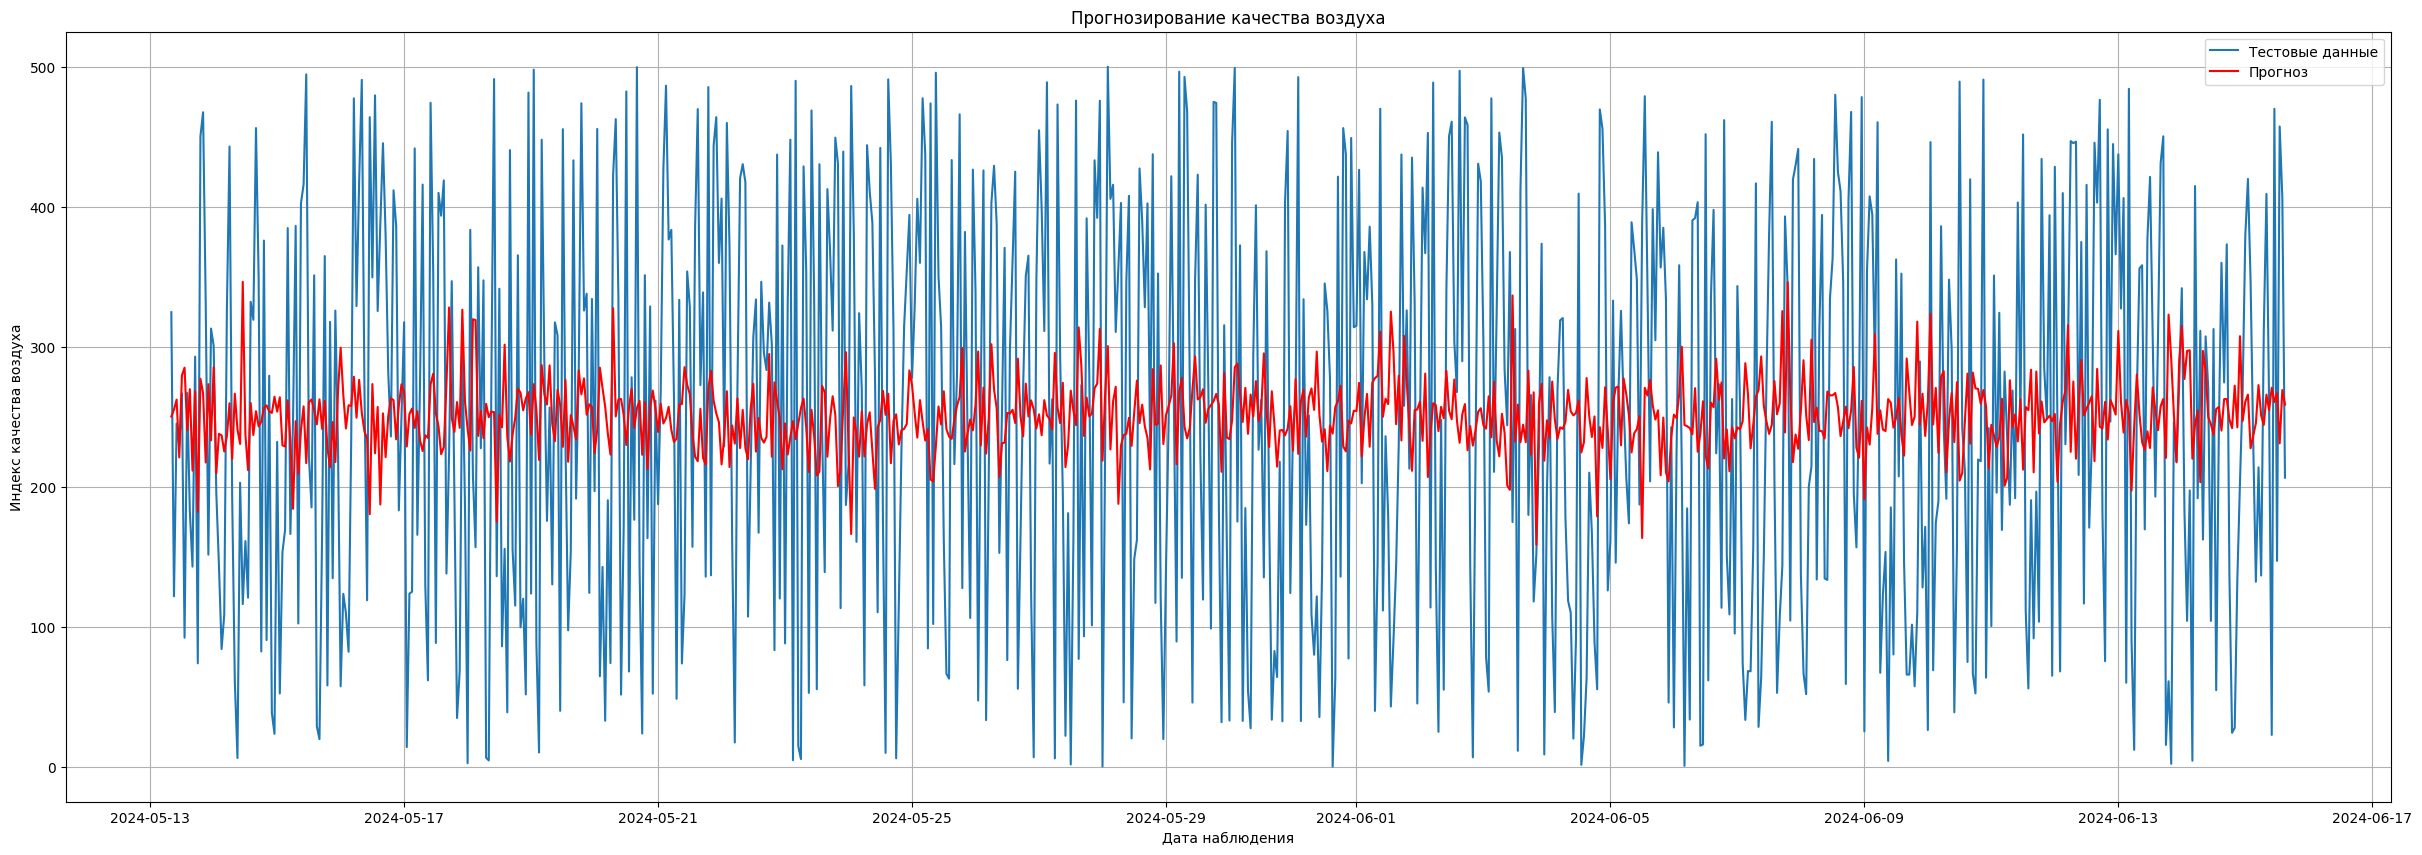

Mean Absolute Error (MAE): 134.568
Mean Squared Error (MSE): 25592.521
Root Mean Squared Error (RMSE): 159.977


In [275]:
# Визуализация прогноза
plt.figure(figsize=(30, 10))
plt.plot(X_xgb_test.index, y_xgb_test, label='Тестовые данные')
plt.plot(X_xgb_test.index, forecast_gb, color='red', label='Прогноз')
plt.title('Прогнозирование качества воздуха')
plt.xlabel('Дата наблюдения')
plt.ylabel('Индекс качества воздуха')
plt.legend()
plt.grid(True)
plt.show()

# Оценка точности прогноза
mse = mean_squared_error(y_xgb_test, forecast_xgb)
mae = mean_absolute_error(y_xgb_test, forecast_xgb)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

In [276]:
# Использование Exponential Smoothing для прогноза

es_data_train = data_cleaned[0:3200]
es_data_test = data_cleaned[3200:4000]

model_es = ExponentialSmoothing(es_data_train['AirQualityIndex']).fit()
forecast_es = model_es.forecast(len(es_data_test['AirQualityIndex']))

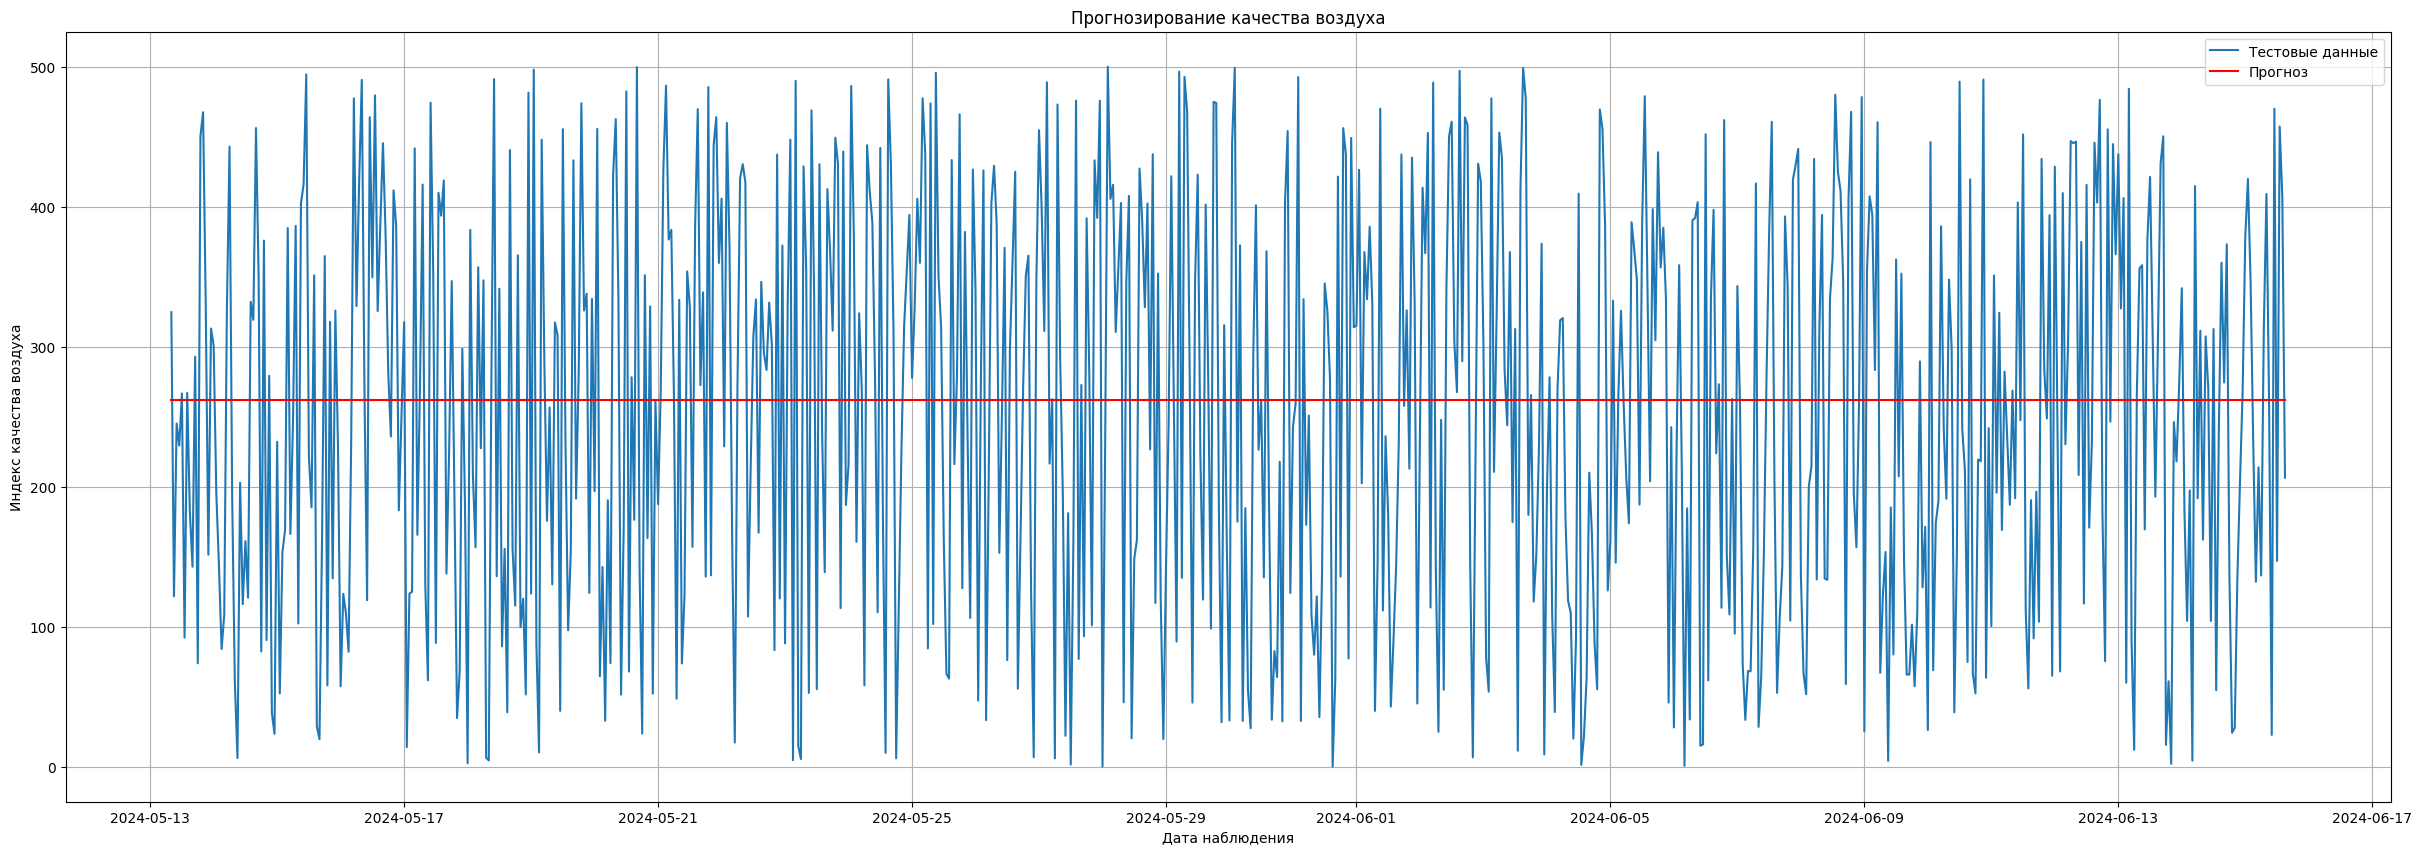

Mean Absolute Error (MAE): 127.278
Mean Squared Error (MSE): 21229.647
Root Mean Squared Error (RMSE): 145.704


In [277]:
# Визуализация прогноза
plt.figure(figsize=(30, 10))
plt.plot(es_data_test.index, es_data_test['AirQualityIndex'], label='Тестовые данные')
plt.plot(es_data_test.index, forecast_es, color='red', label='Прогноз')
plt.title('Прогнозирование качества воздуха')
plt.xlabel('Дата наблюдения')
plt.ylabel('Индекс качества воздуха')
plt.legend()
plt.grid(True)
plt.show()

# Оценка точности прогноза
mse = mean_squared_error(es_data_test['AirQualityIndex'], forecast_es)
mae = mean_absolute_error(es_data_test['AirQualityIndex'], forecast_es)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

In [278]:
# Ансамбль моделей

ensemble_data = data_cleaned

X_ensemble = ensemble_data.drop('AirQualityIndex', axis=1)
y_ensemble = ensemble_data['AirQualityIndex']

X_ensemble_train = X_ensemble[0:3200]
X_ensemble_test = X_ensemble[3200:4000]
y_ensemble_train = y_ensemble[0:3200]
y_ensemble_test = y_ensemble[3200:4000]


ensemble = VotingRegressor([
    ('rf', model_forest),
    ('gb', model_gb),
    ('xgb', model_xgb)
])
ensemble.fit(X_ensemble_train, y_ensemble_train)
forecast_ensemble = ensemble.predict(X_ensemble_test)

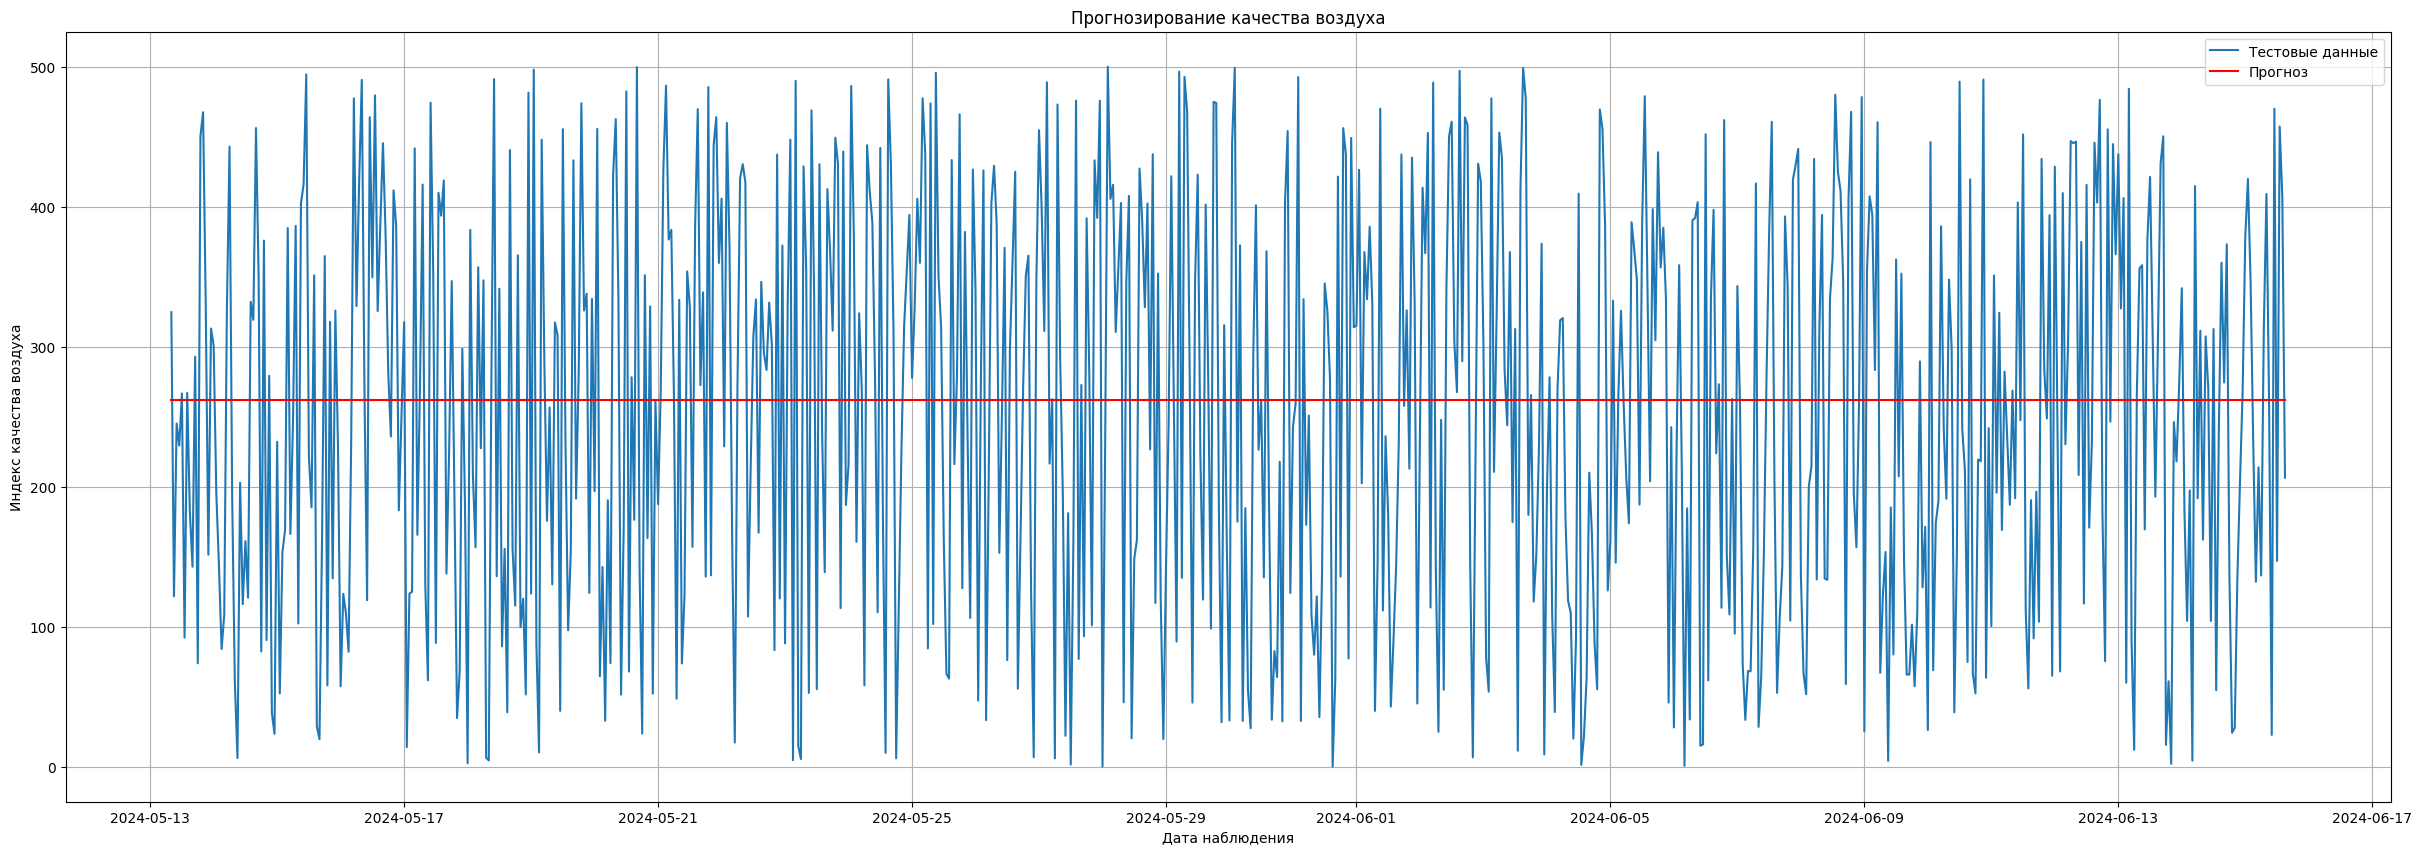

Mean Absolute Error (MAE): 129.154
Mean Squared Error (MSE): 22251.782
Root Mean Squared Error (RMSE): 149.170


In [279]:
# Визуализация прогноза
plt.figure(figsize=(30, 10))
plt.plot(X_ensemble_test.index, y_ensemble_test, label='Тестовые данные')
plt.plot(X_ensemble_test.index, forecast_es, color='red', label='Прогноз')
plt.title('Прогнозирование качества воздуха')
plt.xlabel('Дата наблюдения')
plt.ylabel('Индекс качества воздуха')
plt.legend()
plt.grid(True)
plt.show()

# Оценка точности прогноза
mse = mean_squared_error(y_ensemble_test, forecast_ensemble)
mae = mean_absolute_error(y_ensemble_test, forecast_ensemble)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")